Todo: 

* Classifier per hero * role

In [1]:
import os
import json
import numpy as np
import pickle 
import tqdm
import gzip
import tarfile

In [2]:
# with tarfile.open("../data/parsed/opendota_parsed_matches.tar.gz", 'r:gz') as zfp:
#     for filename in zfp.getnames():
#         match = pickle.load(zfp.extractfile(filename))
#         print(match)
#         break

zfp = tarfile.open("../data/opendota_parsed_matches.tar.gz", 'r:gz')
all_filenames = zfp.getnames()

In [3]:
filenames = all_filenames[1:]

In [4]:
# fp = zfp.extractfile(filenames[0])
# fp.seek(0)
# match = pickle.loads(fp.read())

In [5]:

def get_rank(rank: int):
    oh = np.zeros(5)
    oh[rank] = 1
    return oh

def extract_data_point(match):
    players = match["players"]
    t0 = list(filter(lambda p: p["isRadiant"], players))
    t1 = list(filter(lambda p: not p["isRadiant"], players))
    team = [t0, t1]

    xs = []
    ys = []
    for i in [0, 1]:
        hids = [p["hero_id"] for p in team[i]]
        gpm_rank = sorted([(p["hero_id"], p["gold_per_min"]) for p in team[i]], key=lambda x: x[1], reverse=True)
        xpm_rank = sorted([(p["hero_id"], p["xp_per_min"]) for p in team[i]], key=lambda x: x[1], reverse=True)
        ka_rank = sorted([(p["hero_id"], p["kills"] + p["assists"]) for p in team[i]], key=lambda x: x[1], reverse=True)
        d_rank = sorted([(p["hero_id"], p["deaths"]) for p in team[i]], key=lambda x: x[1], reverse=True)
        lasthits_rank = sorted([(p["hero_id"], p["last_hits"]) for p in team[i]], key=lambda x: x[1], reverse=True)
        wards_placed = []


        for p in team[i]:
            item_uses = p["item_uses"]
            c = 0
            if "ward_observer" in item_uses:
                c += item_uses["ward_observer"]
            if "ward_sentry" in item_uses:
                c += item_uses["ward_sentry"]
            wards_placed.append((p["hero_id"], c))

        wards_placed = list(sorted(wards_placed, key=lambda x: x[1], reverse=True))

        for h in team[i]:
            features = []
            hid = h["hero_id"]
            
            onehot_hero = np.zeros((136))
            onehot_hero[hid] = 1
            features.append(onehot_hero)

            onehot_heroes = np.zeros((136))
            for team_hid in hids:
                onehot_heroes[team_hid] = 1
            
            features.append(onehot_heroes)
            features.append(get_rank(gpm_rank.index((hid, h["gold_per_min"]))))
            features.append(get_rank(xpm_rank.index((hid, h["xp_per_min"]))))
            features.append(get_rank(ka_rank.index((hid,  h["kills"] + h["assists"]))))
            features.append(get_rank(d_rank.index((hid, h["deaths"]))))
            features.append(get_rank(lasthits_rank.index((hid, h["last_hits"]))))
    
            if hid == wards_placed[0][0]:
                y = 4
            else:
                y = h["lane_role"]
            xs.append(np.concatenate(features))
            ys.append(y)

    return xs, ys

trainingset = []
labels = []

for fname in tqdm.tqdm(filenames):
    fp = zfp.extractfile(fname)
    fp.seek(0)
    match = pickle.loads(fp.read())
    xs, ys = extract_data_point(match)
    trainingset.append(np.vstack(xs))
    labels.append(ys)
    
# fp = zfp.extractfile(filenames[0])
# fp.seek(0)
# match = pickle.loads(fp.read())


# x_train, y = extract_data_point(match)
# for r in x_train:
#     print(r.shape)

# x = np.vstack(x_train)
# print(len(trainingset))
# print(len(trainingset))
# print(np.array(trainingset).shape)

100%|██████████| 50000/50000 [03:19<00:00, 250.77it/s]


In [6]:
x = np.vstack(trainingset)
y = np.array(labels).ravel()
np.unique(y)

array([1, 2, 3, 4])

<AxesSubplot:ylabel='Frequency'>

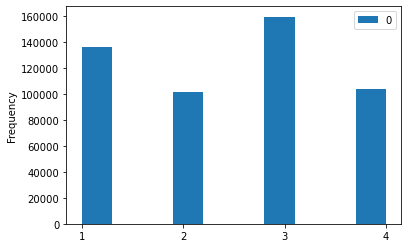

In [7]:
import pandas as pd

df = pd.DataFrame(y)
df.plot.hist(xticks=[1, 2, 3, 4])

In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.46095
[[14008    19 12221   995]
 [ 7085   646 12442    73]
 [ 2164    11 28956   810]
 [  854     4 17227  2485]]


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split


# for hero, train a logistic regression model and add to VotingClassifier
estimators = []


clf = LogisticRegression(multi_class='multinomial', random_state=1)

eclf1 = VotingClassifier(estimators=estimators, voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
print(eclf1.predict(x_test))

[3 3 2 ... 4 4 4]


In [12]:
np.array_equal(eclf1.named_estimators_.lr.predict(x), eclf1.named_estimators_['lr'].predict(x))

True